In [120]:
import pip
# pip.main(['install', '{insert_pckg_here}'])
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data normalization and standardization 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN

#Training and testing split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn import svm

#Evalution
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


## Loading Training/Testing Data:

In [121]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

training_set = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
testing_set = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')

train_df = pd.DataFrame(training_set)
test_df = pd.DataFrame(testing_set)

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Preprocessing:

In [122]:
# create df that consists of columns and the number of missing values for each 
data = train_df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

# add column and fill it with the percentage of those missing values
missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/train_df.shape[0] * 100)) 
missing_df = missing_df[missing_df.missing_cnt > 0]
missing_df



,missing_cnt,percent_missing
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageCond,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


In [123]:
# drop the columns where majority of their values are missing
# train_df = train_df.drop(['PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu'], axis = 1)
# train_df.head()

In [124]:
train_df1 = pd.get_dummies(data=train_df , columns=['MSZoning','Street', 'Alley', 'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                                                   'BldgType', 'HouseStyle'])
train_df1.head()

,MSSubClass,LotFrontage,LotArea,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,...,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Norm,Norm,7,5,2003,2003,Gable,...,0,0,0,0,0,0,0,1,0,0
2,20,80.0,9600,Feedr,Norm,6,8,1976,1976,Gable,...,0,0,0,0,1,0,0,0,0,0
3,60,68.0,11250,Norm,Norm,7,5,2001,2002,Gable,...,0,0,0,0,0,0,0,1,0,0
4,70,60.0,9550,Norm,Norm,7,5,1915,1970,Gable,...,0,0,0,0,0,0,0,1,0,0
5,60,84.0,14260,Norm,Norm,8,5,2000,2000,Gable,...,0,0,0,0,0,0,0,1,0,0


In [125]:
# creating a generic dictionary to hold numercial values to represent categorical values
# for quality related columns (ExterQual, BsmtQual)
quality_ratings = {
 'NA':0,
 'Po':0.2, 
 'Fa':0.4, 
 'TA':0.6, 
 'Gd':0.8, 
 'Ex':1
}

In [126]:
# conda install ecos
# conda install CVXcanon
# !pip install fancyimpute

In [127]:
train_df['CentralAir'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0})
train_df['PavedDrive'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0.5,
 'P': 0})
train_df.head()

test_df['CentralAir'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0})
test_df['PavedDrive'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0.5,
 'P': 0})
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [128]:
# Converting category labels to numerical values for ExterQual column
train_df['ExterQual'] = train_df.ExterQual.map(quality_ratings)
test_df['ExterQual'] = test_df.ExterQual.map(quality_ratings)
train_df['ExterQual']

Id
1       0.8
2       0.6
3       0.8
4       0.6
5       0.8
       ... 
1456    0.6
1457    0.6
1458    1.0
1459    0.6
1460    0.8
Name: ExterQual, Length: 1460, dtype: float64

In [129]:
# Converting category labels to numerical values for BsmtQual column
train_df['BsmtQual'] = train_df.BsmtQual.map(quality_ratings)
test_df['BsmtQual'] = train_df.BsmtQual.map(quality_ratings)

In [130]:
# Converting category labels to numerical values for HeatingQC column
train_df['HeatingQC'] = train_df.HeatingQC.map(quality_ratings)
test_df['HeatingQC'] = train_df.HeatingQC.map(quality_ratings)

In [131]:
# Converting category labels to numerical values for KitchenQual column
train_df['KitchenQual'] = train_df.KitchenQual.map(quality_ratings)
test_df['KitchenQual'] = train_df.KitchenQual.map(quality_ratings)

In [132]:
# Converting category labels to numerical values for GarageQual column
train_df['GarageQual'] = train_df.GarageQual.map(quality_ratings)
test_df['GarageQual'] = train_df.GarageQual.map(quality_ratings)

In [133]:
# # Converting category labels to numerical values for SaleCondition column
# train_df['SaleCondition_Num'] = train_df.SaleCondition.map(
# {'Abnorml':1, 
#  'AdjLand':2, 
#  'Alloca':3, 
#  'Family':4, 
#  'Normal':5,
#  'Partial':6})

In [135]:
train_df = pd.get_dummies(data=train_df , columns=['MSZoning','Street', 'Alley', 'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                                                   'MasVnrType', 'ExterCond', 'Foundation',
                                                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
                                                   'Heating', 'Electrical',  
                                                   'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                                                   'GarageCond', 'PoolQC', 'Fence',
                                                  'MiscFeature', 'SaleType', 'SaleCondition'])
train_df.head()

test_df = pd.get_dummies(data=test_df , columns=['MSZoning','Street', 'Alley', 'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                                                   'MasVnrType' ,'ExterCond', 'Foundation',
                                                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
                                                   'Heating', 'Electrical',  
                                                   'Functional', 'FireplaceQu','GarageType', 'GarageFinish',
                                                   'GarageCond', 'PoolQC', 'Fence',
                                                  'MiscFeature', 'SaleType', 'SaleCondition'])
test_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,11622,5,6,1961,1961,0.0,0.6,NaN,...,0,0,0,1,0,0,0,0,1,0
1462,20,81.0,14267,6,6,1958,1958,108.0,0.6,NaN,...,0,0,0,1,0,0,0,0,1,0
1463,60,74.0,13830,5,5,1997,1998,0.0,0.6,NaN,...,0,0,0,1,0,0,0,0,1,0
1464,60,78.0,9978,6,6,1998,1998,20.0,0.6,NaN,...,0,0,0,1,0,0,0,0,1,0
1465,120,43.0,5005,8,5,1992,1992,0.0,0.8,NaN,...,0,0,0,1,0,0,0,0,1,0


In [103]:
# # NA is a valid value and is some cases not equivalent to NaN and should not be converted to 0
# # replace null values in df w/ values that had most counts for each column
# train_df1 = train_df1.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
#                           else x.fillna(train_df.columns.value_counts().idxmax()))
# test_df = test_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
#                           else x.fillna(train_df.columns.value_counts().idxmax()))

In [104]:
# # encode object (categorical) columns in df
# enc_df = train_df1.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

# # add encoded columns back into original train df
# train_df1[enc_df.columns] = enc_df

# train_df1.head()

In [136]:
train_filled_knn = KNN(k=1).fit_transform(train_df)   
train_df = pd.DataFrame(train_filled_knn, columns = list(train_df.columns))
train_df.head()

test_filled_knn = KNN(k=1).fit_transform(test_df)   
test_df = pd.DataFrame(test_filled_knn, columns = list(test_df.columns))
test_df.head()

Imputing row 1/1460 with 2 missing, elapsed time: 3.274
Imputing row 101/1460 with 3 missing, elapsed time: 3.278
Imputing row 201/1460 with 2 missing, elapsed time: 3.281
Imputing row 301/1460 with 2 missing, elapsed time: 3.285
Imputing row 401/1460 with 2 missing, elapsed time: 3.288
Imputing row 501/1460 with 2 missing, elapsed time: 3.293
Imputing row 601/1460 with 2 missing, elapsed time: 3.298
Imputing row 701/1460 with 2 missing, elapsed time: 3.302
Imputing row 801/1460 with 2 missing, elapsed time: 3.306
Imputing row 901/1460 with 3 missing, elapsed time: 3.309
Imputing row 1001/1460 with 3 missing, elapsed time: 3.313
Imputing row 1101/1460 with 2 missing, elapsed time: 3.317
Imputing row 1201/1460 with 2 missing, elapsed time: 3.320
Imputing row 1301/1460 with 3 missing, elapsed time: 3.324
Imputing row 1401/1460 with 2 missing, elapsed time: 3.328
[KNN] Warning: 2920/392740 still missing after imputation, replacing with 0
Imputing row 1/1459 with 6 missing, elapsed time: 3

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,0.6,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,0.6,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,0.6,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,0.6,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,0.8,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [137]:
test_df.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 251, dtype: int64

## Exploratory Data Analysis (EDA)

In [139]:

corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
corr_matrix['SalePrice']

MSSubClass              -0.0843
LotFrontage              0.3251
LotArea                  0.2638
OverallQual              0.7910
OverallCond             -0.0779
                          ...  
SaleCondition_AdjLand   -0.0507
SaleCondition_Alloca    -0.0155
SaleCondition_Family    -0.0465
SaleCondition_Normal    -0.1540
SaleCondition_Partial    0.3521
Name: SalePrice, Length: 269, dtype: float64

In [79]:
#feture selection

In [80]:
#Independent Variable
X = train_df.loc[:,~train_df.columns.isin(['SalePrice'])]
X_scaled = preprocessing.scale(X)

#Dependent Variable
y = train_df.loc[:,'SalePrice']

# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import VarianceThreshold

# X = VarianceThreshold(threshold=(.8 * (1 - .8)))
# X.fit_transform(XData)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 42)

## Data normalization and standardization

In [81]:
#Data normalization and standardization
rescaledX_train = preprocessing.scale(X_train)
rescaledX_test = preprocessing.scale(X_test)

### Logestic Regression ###

In [82]:
logReg = LogisticRegression(random_state = 42,solver='lbfgs', max_iter=300000)
logReg.fit(rescaledX_train,y_train)

LogisticRegression(max_iter=300000, random_state=42)

In [33]:
#Model1 Evalution

y_pred = logReg.predict(rescaledX_test)
print('Accuracy of logistic regression classifier:', accuracy_score(y_test,y_pred))
# print('Roc Auc Score:',roc_auc_score(y_test,y_pred))
print('Confusion Matrix of the logreg model: ',confusion_matrix(y_test,y_pred))

Accuracy of logistic regression classifier: 0.0
Confusion Matrix of the logreg model:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### SVM ### 

In [83]:
classification_svm =svm.SVC()
classification_svm.fit(rescaledX_train,y_train)

SVC()

In [84]:
y_pred = classification_svm.predict(rescaledX_test)

print('Accuracy of SVM classifier:', accuracy_score(y_test,y_pred))
# print('Roc Auc Score:',roc_auc_score(y_test,y_pred))
print('Confusion Matrix of the SVM model: ',confusion_matrix(y_test,y_pred))

Accuracy of SVM classifier: 0.0136986301369863
Confusion Matrix of the SVM model:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# encode object (categorical) columns in df
enc_df = train_df.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

# add encoded columns back into original train df
train_df[enc_df.columns] = enc_df
train_df.head()

In [ ]:
#print(train_df.MSZoning)

#df = train_df.groupby('MSZoning').size()
#print (df)

# Converting category labels to numerical values for MSZoning column
train_df['MSZoning_Num'] = train_df.MSZoning.map(
{'C (all)': 1,
 'FV': 2,
 'RH': 3,
 'RL': 4,
 'RM': 5})

#print(train_df.MSZoning_Num)

In [ ]:
#print(train_df.LotConfig)

#df = train_df.groupby('LotConfig').size()
#print (df)

# Converting category labels to numerical values for LotConfig column
train_df['LotConfig_Num'] = train_df.LotConfig.map(
{'Corner': 1,
 'CulDSac': 2,
 'FR2': 3,
 'FR3': 4,
 'Inside': 5})

#print(train_df.LotConfig_Num)    

In [ ]:
#print(train_df.Neighborhood)

#df = train_df.groupby('Neighborhood').size()
#print (df)

# Converting category labels to numerical values for Neighborhood column
train_df['Neighborhood_Num'] = train_df.Neighborhood.map(
{'Blmngtn': 1,
 'Blueste': 2,
 'BrDale': 3,
 'BrkSide': 4,
 'ClearCr': 5,
 'CollgCr': 6,
 'Crawfor': 7,
 'Edwards': 8,
 'Gilbert': 9,
 'IDOTRR':  10,
 'MeadowV': 11,
 'Mitchel': 12,
 'NAmes': 13,
 'NPkVill': 14,
 'NWAmes': 15,
 'NoRidge': 16,
 'NridgHt': 17,
 'OldTown': 18,
 'SWISU': 19,
 'Sawyer': 20,
 'SawyerW': 21,
 'Somerst': 22,
 'StoneBr': 23,
 'Timber': 24,
 'Veenker': 25})

#print(train_df.Neighborhood_Num)

In [ ]:
#print(train_df.KitchenQual)

#df = train_df.groupby('KitchenQual').size()
#print (df)

# Converting category labels to numerical values for KitchenQual column
train_df['KitchenQual_Num'] = train_df.KitchenQual.map(
{'Po':1, 
 'Fa':2, 
 'TA':3, 
 'Gd':4, 
 'Ex':5})

#print(train_df.KitchenQual_Num)

In [ ]:
#print(train_df.SaleCondition)

#df = train_df.groupby('SaleCondition').size()
#print (df)

# Converting category labels to numerical values for SaleCondition column
train_df['SaleCondition_Num'] = train_df.SaleCondition.map(
{'Abnorml':1, 
 'AdjLand':2, 
 'Alloca':3, 
 'Family':4, 
 'Normal':5,
 'Partial':6})

#print(train_df.SaleCondition_Num)

## Data Exploration:

array([[<AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

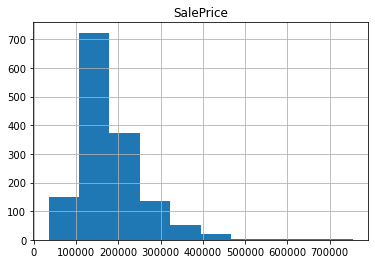

In [140]:
# check distribution of sales price
train_df1.hist(column='SalePrice')

array([[<AxesSubplot:title={'center':'LogPrice'}>]], dtype=object)

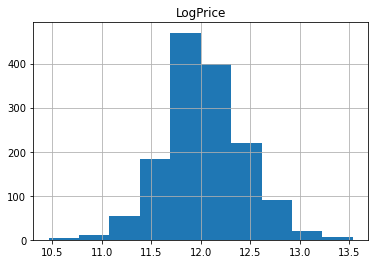

In [141]:
# normalize sale price so that it can be evenly distributed
train_df1['LogPrice'] = np.log(train_df1.SalePrice)
train_df1.hist(column='LogPrice')

In [142]:
# check for more skewed columns
train_df1.skew().sort_values(ascending=False).head(30)

Utilities_NoSeWa        38.209946
Neighborhood_Blueste    26.990701
MiscVal                 24.476794
LotConfig_FR3           19.045943
Street_Grvl             15.518770
PoolArea                14.828374
HouseStyle_2.5Fin       13.411750
Neighborhood_NPkVill    12.631556
LotArea                 12.207688
LotShape_IR3            11.970851
MSZoning_C (all)        11.970851
Neighborhood_Veenker    11.401839
HouseStyle_2.5Unf       11.401839
LandSlope_Sev           10.466218
3SsnPorch               10.304342
HouseStyle_1.5Unf       10.074915
MSZoning_RH              9.404402
Neighborhood_BrDale      9.404402
Neighborhood_MeadowV     9.113988
Neighborhood_Blmngtn     9.113988
LowQualFinSF             9.011341
Neighborhood_StoneBr     7.451946
Neighborhood_SWISU       7.451946
Neighborhood_ClearCr     7.018804
BldgType_2fmCon          6.649007
LandContour_Low          6.136628
HouseStyle_SFoyer        6.046534
Neighborhood_IDOTRR      6.046534
Neighborhood_Timber      5.959928
LotShape_IR2  

In [143]:
# looking at correlation of numeric features to SalePrice column. 
# this will suggest which columns have a greater relationship with the SalePrice column 
corr = train_df1.corr().abs().unstack().sort_values(ascending=False)['LogPrice']
corr = corr.iloc[1:]
corr = pd.DataFrame(corr, columns = ['Correlation'])

corr = corr[corr.Correlation > 0.50]
corr

,Correlation
SalePrice,0.948374
OverallQual,0.817184
GrLivArea,0.700927
GarageCars,0.680625
GarageArea,0.650888
TotalBsmtSF,0.612134
1stFlrSF,0.596981
FullBath,0.594771
YearBuilt,0.586570
YearRemodAdd,0.565608


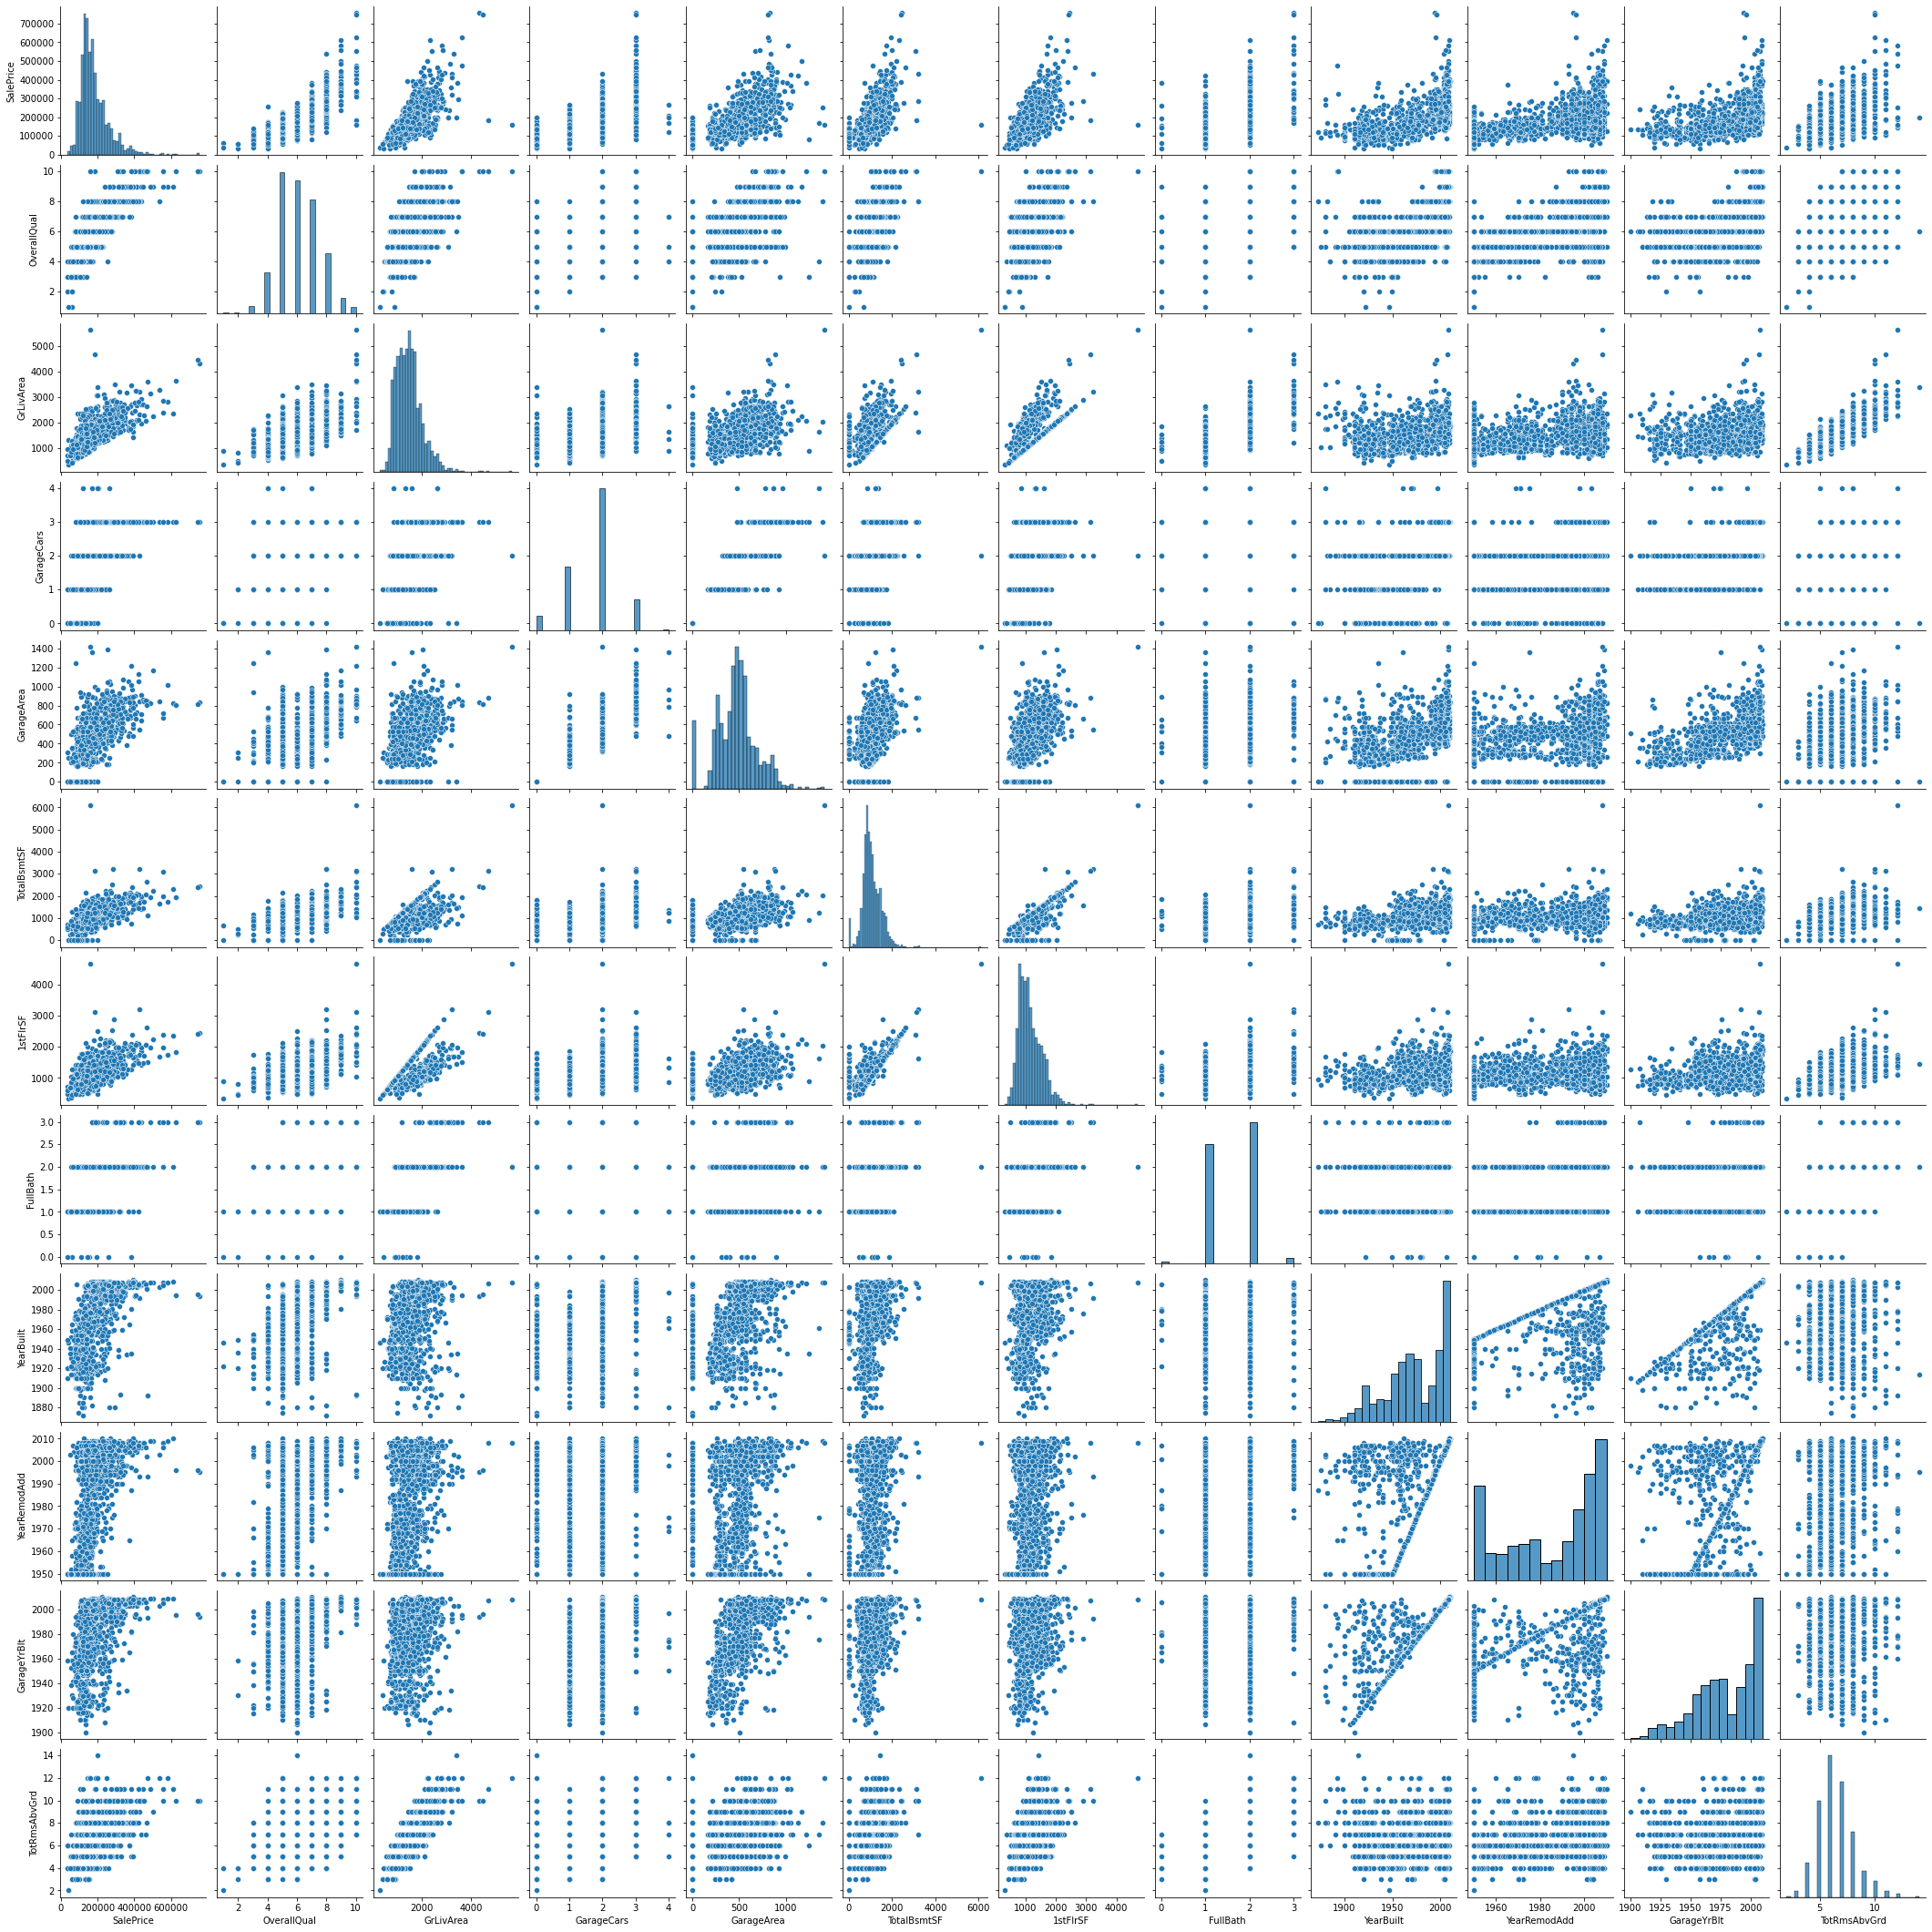

In [144]:
cols = []
for ind in corr.index:
    cols.append(ind)

# create pair plot between columns that have correlation 50% and above
sns.pairplot(train_df1[cols])

## Data Visualization (CAN BE DELETED):

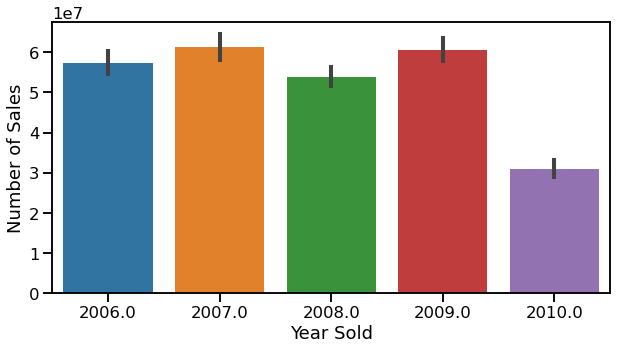

In [145]:
#Count the number of houses sold in a year
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc='count')
#print(year_sold_pivot)

# Plotting the sum of sales per year
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=sum)
plt.xlabel('Year Sold')
plt.ylabel('Number of Sales')
plt.show()

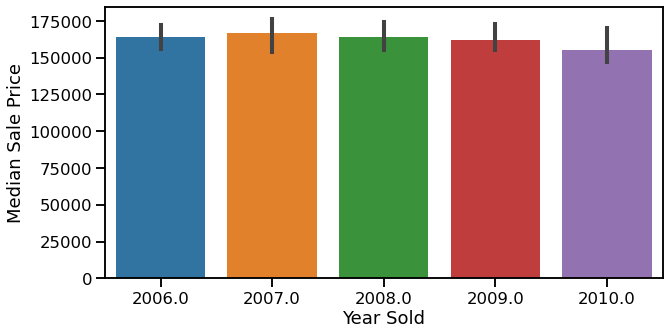

In [146]:
# Plotting the median sale price for each year

#Checking the median price
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc=np.median)
#print(year_sold_pivot)

sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=np.median)
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

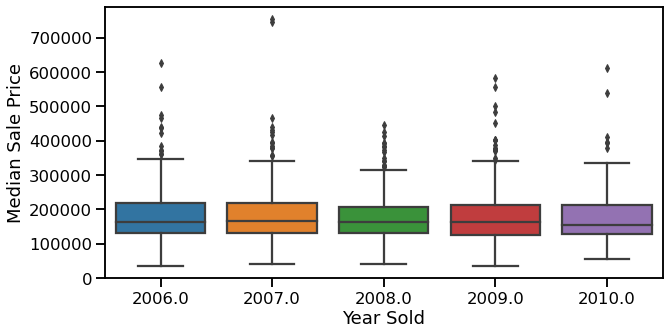

In [147]:
#Displaying the median price for each year using box plot.  
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.boxplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']])
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

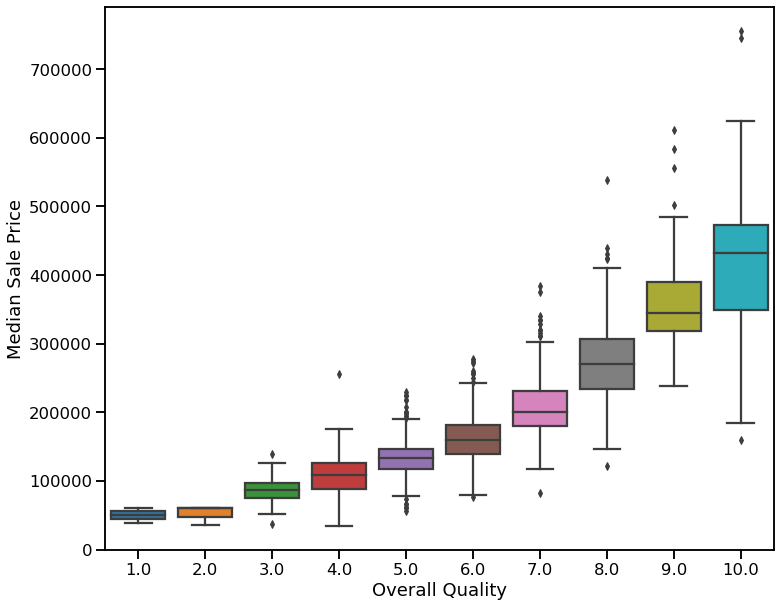

In [148]:
# Displaying the median price based on overall quality of the house using box plot.
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(12,10))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df[['SalePrice', 'OverallQual']])
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

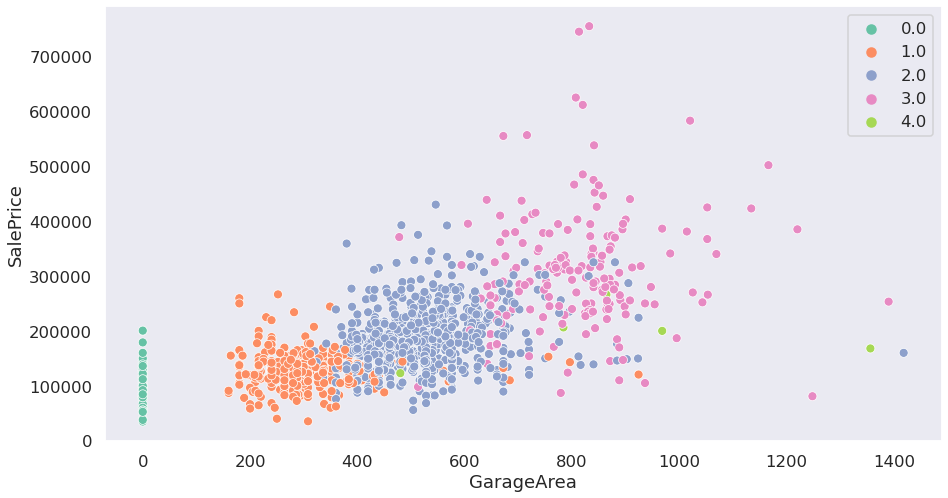

In [149]:
sns.set_context('talk', font_scale=1) 
sns.set_style('dark')
plt.figure(figsize=(15,8))

# Plot GarageArea vs sale price of house considering the number of cars that can
# fit in the garage
sns.scatterplot(x='GarageArea', y='SalePrice', hue=train_df.GarageCars.tolist(),
            palette='Set2', data=train_df[['SalePrice', 'GarageArea','GarageCars']])
plt.show()

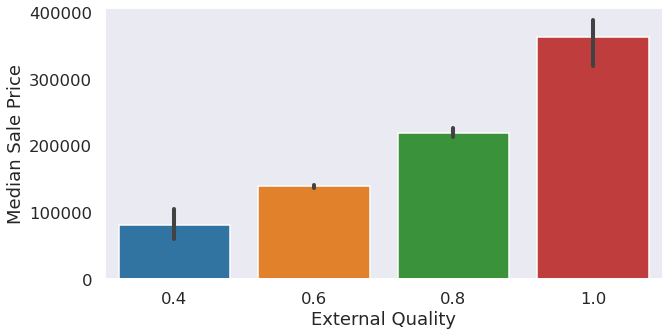

In [150]:
# Plotting the median sale price based on external quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='ExterQual', y='SalePrice', data=train_df[['SalePrice', 'ExterQual']], estimator=np.median)
plt.xlabel('External Quality')
plt.ylabel('Median Sale Price')
plt.show()

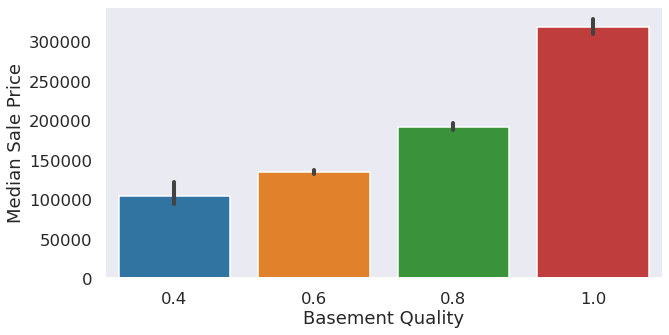

In [151]:
# Plotting the median sale price based on basement quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='BsmtQual', y='SalePrice', data=train_df[['SalePrice', 'BsmtQual']], estimator=np.median)
plt.xlabel('Basement Quality')
plt.ylabel('Median Sale Price')
plt.show()

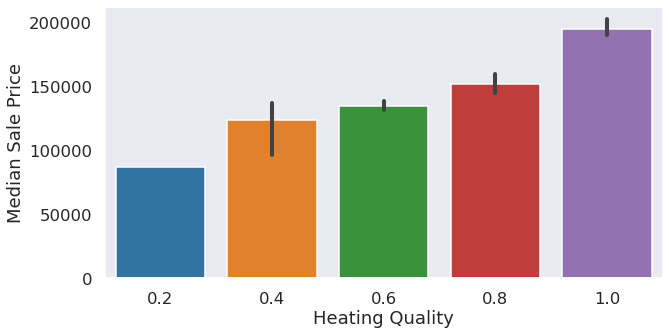

In [152]:
# Plotting the median sale price based on heating and air conditioning quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='HeatingQC', y='SalePrice', data=train_df[['SalePrice', 'HeatingQC']], estimator=np.median)
plt.xlabel('Heating Quality')
plt.ylabel('Median Sale Price')
plt.show()

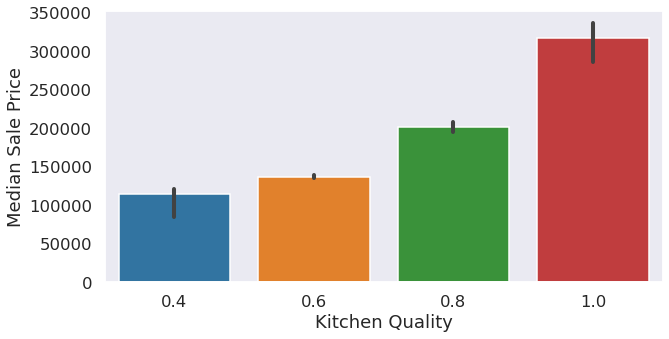

In [153]:
# Plotting the median sale price based on kitchen quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='KitchenQual', y='SalePrice', data=train_df[['SalePrice', 'KitchenQual']], estimator=np.median)
plt.xlabel('Kitchen Quality')
plt.ylabel('Median Sale Price')
plt.show()

In [155]:
# # Plotting the median sale price based on fireplace quality
# sns.set_context('talk', font_scale=1) 
# plt.figure(figsize=(10,5))
# sns.barplot(x='FireplaceQu', y='SalePrice', data=train_df[['SalePrice', 'FireplaceQu']], estimator=np.median)
# plt.xlabel('Fireplace Quality')
# plt.ylabel('Median Sale Price')
# plt.show()

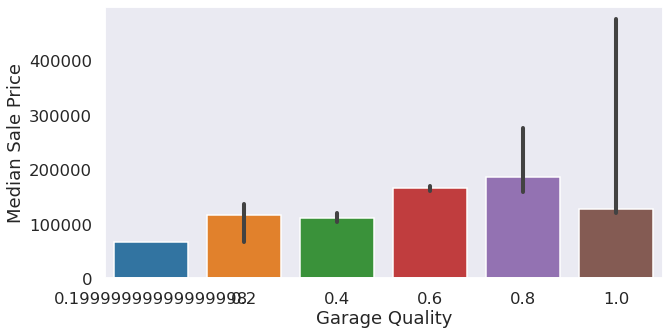

In [156]:
# Plotting the median sale price based on garage quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='GarageQual', y='SalePrice', data=train_df[['SalePrice', 'GarageQual']], estimator=np.median)
plt.xlabel('Garage Quality')
plt.ylabel('Median Sale Price')
plt.show()

In [158]:
# # Plotting the median sale price based on pool quality
# sns.set_context('talk', font_scale=1) 
# plt.figure(figsize=(10,5))
# sns.barplot(x='PoolQC', y='SalePrice', data=train_df[['SalePrice', 'PoolQC']], estimator=np.median)
# plt.xlabel('Pool Quality')
# plt.ylabel('Median Sale Price')
# plt.show()

## Feature Engineering:

In [ ]:
# sum of quality points.
train_df['SumQuality'] = train_df.ExterQual_Num + train_df.BsmtQual_Num + train_df.HeatingQC_Num + train_df.KitchenQual_Num + train_df.GarageQual_Num + train_df.FireplaceQu_Num + train_df.GarageQual_Num + train_df.PoolQC_Num 
            
#print(train_df['SumQuality'])

# sum of quality points, removing less correlated features (< 0.5).
train_df['SumMIQ'] = train_df.ExterQual_Num + train_df.BsmtQual_Num + train_df.KitchenQual_Num + train_df.FireplaceQu_Num + train_df.GarageQual_Num

In [ ]:
# Garage area per car
# May not need this one, the correlation to SalePrice is only slightly higher than GarageArea
train_df['GarageAreaPerCar'] = train_df.GarageArea + train_df.GarageCars 

#print(train_df['GarageAreaPerCar'])

In [ ]:
corr = train_df.corr().abs().unstack().sort_values(ascending=False)['SalePrice']
corr.head(40)

In [ ]:
# Ratio of Basement Quality ['BsmtQual'] to Overall Quality ['OverallQual']

In [ ]:
# Ratio of Exterior Quality ['ExterQual'] to Overall Quality ['OverallQual']

In [ ]:
# Ratio of Kitchen Quality ['KitchenQual'] to Overall Quality ['OverallQual']

In [ ]:
################## DISREGARD LOGIC BELOW ######################

In [ ]:
# encode object columns
# enc_df = train_df.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)
# enc_df

In [ ]:
# add encoded columns back into train df
# train_df[enc_df.columns] = enc_df
# train_df

In [ ]:
# normalize df except for price column
# norm_df = (train_df - train_df.mean()) / (train_df.max() - train_df.min())